# Classification of CIFAR10 [dataset](http://www.cs.toronto.edu/~kriz/cifar.html) using PyTorch

**Classification of CIFAR10 dataset using CNN - PyTorch framework on both CPU and GPU.**
<br><br><br>
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 

In [19]:
#Metadata
%load_ext watermark
%watermark -a "Vutsal Singhal" -p numpy,matplotlib,torch -u -n -t -z -m

Vutsal Singhal 
last updated: Sun Jan 14 2018 18:46:53 EST

numpy 1.13.3
matplotlib 2.1.0
torch 0.3.0.post4

compiler   : GCC 5.4.0 20160609
system     : Linux
release    : 4.13.0-26-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset    = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,shuffle=True, num_workers=2)

testset    = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


shape:  torch.Size([3, 36, 138])


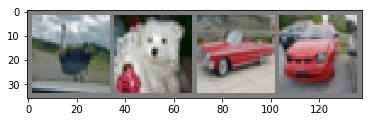

     bird       dog       car       car


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    print("shape: ",img.shape)
    img   = img/2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%9s' % classes[labels[j]] for j in range(4)))

## Define NN

In [4]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16 * 5 * 5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

---
## CPU Training
---

## Define a Loss function and optimizer

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train the network

In [50]:
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)

        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.222
[1,  4000] loss: 1.804
[1,  6000] loss: 1.644
[1,  8000] loss: 1.547
[1, 10000] loss: 1.486
[1, 12000] loss: 1.440
[2,  2000] loss: 1.377
[2,  4000] loss: 1.356
[2,  6000] loss: 1.318
[2,  8000] loss: 1.285
[2, 10000] loss: 1.294
[2, 12000] loss: 1.256
Finished Training


## Test the network on the test data

shape:  torch.Size([3, 36, 138])


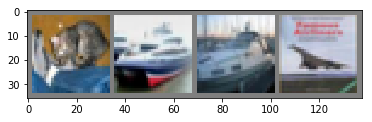

GroundTruth:    cat  ship  ship plane


In [51]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [53]:
outputs = net(Variable(images))
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship  ship  ship


Testing on the entire test data

In [54]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 57 %


- Finding the classes that performed well, and the classes that did not perform well:

In [55]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 56 %
Accuracy of   car : 74 %
Accuracy of  bird : 45 %
Accuracy of   cat : 39 %
Accuracy of  deer : 46 %
Accuracy of   dog : 50 %
Accuracy of  frog : 70 %
Accuracy of horse : 61 %
Accuracy of  ship : 78 %
Accuracy of truck : 49 %


---
## Training on GPU
---

In [6]:
net = net.cuda()

## Define a Loss function and optimizer

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train the network

In [8]:
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        
        #Remember that you will have to send the inputs and targets at every step to the GPU too
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.197
[1,  4000] loss: 1.848
[1,  6000] loss: 1.668
[1,  8000] loss: 1.575
[1, 10000] loss: 1.485
[1, 12000] loss: 1.476
[2,  2000] loss: 1.386
[2,  4000] loss: 1.347
[2,  6000] loss: 1.330
[2,  8000] loss: 1.302
[2, 10000] loss: 1.282
[2, 12000] loss: 1.243
Finished Training


## Test the network on the test data

shape:  torch.Size([3, 36, 138])


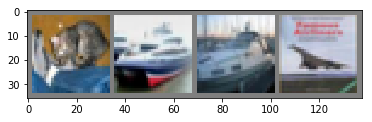

GroundTruth:    cat  ship  ship plane


In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [11]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images.cuda()))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 58 %


Finding the classes that performed well, and the classes that did not perform well:

In [12]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    images, labels = images.cuda(), labels.cuda()
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 55 %
Accuracy of   car : 63 %
Accuracy of  bird : 49 %
Accuracy of   cat : 26 %
Accuracy of  deer : 46 %
Accuracy of   dog : 59 %
Accuracy of  frog : 71 %
Accuracy of horse : 66 %
Accuracy of  ship : 71 %
Accuracy of truck : 71 %
